In [1]:
%reset -f
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Generic imports
import matplotlib.pyplot as plt
plt.rc('image', origin='lower', cmap='Blues_r')

import numpy as np
import glob, os

from astropy.wcs import WCS
from astropy.io import fits as fits

from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.time import Time

import astroscrappy

# Disable some annoying warnings from astropy
import warnings
from astropy.wcs import FITSFixedWarning
warnings.simplefilter(action='ignore', category=FITSFixedWarning)
from astropy.utils.exceptions import AstropyUserWarning
warnings.simplefilter(action='ignore', category=AstropyUserWarning)

%cd '~/stdpipe/notebooks/'

/home/karpov/stdpipe/notebooks


# STDPipe - Simple Transient Detection Pipeline
*AKA: random codes noone else will ever use*

*STDPipe* is a set of Python routines for astrometry, photometry and transient detection related tasks, intended for quick and easy implementation of custom pipelines, as well as for interactive data analysis.

Design principles:
 - implemented as a library of routines covering most common tasks
 - operates on standard Python objects: NumPy arrays for images, Astropy Tables for catalogs and object lists, etc
 - does not try to re-implement the things already implemented in other Python packages
 - conveniently wraps external codes that do not have their own Python interfaces (*SExtractor*, *SCAMP*, *PSFEx*, *HOTPANTS*, *Astrometry.Net*, ...)
     - wrapping is transparent: all data passed from Python, all options customizable from Python, all (or most of) outputs available back
     - everything operates on temporary files, nothing is kept after the run unless explicitly asked for

Features:
 - ~~pre-processing~~ - should be handled before in an instrument-specific way
     - bias/dark subtraction, flatfielding, masking
 - object detection and photometry
     - SExtractor or SEP for detection, photutils for photometry 
 - astrometric calibration
     - Astrometry.Net for blind WCS solving
     - SCAMP or Astropy-based code for refinement
 - photometric calibration
     - Vizier catalogues, passband conversion (PS1 to Johnson, Gaia to Johnson, ...)
     - spatial polynomial + color term + intrinsic scatter
 - image subtraction
     - HiPS templates
     - hotpants + custom noise model
 - transient detection and photometry
     - noise-weighted detection, cutout adjustment, ...
 - auxiliary functions
     - PSF estimation, simulated stars, FITS header utilities, plotting, ...
 - light curve creation (soon)
     - spatial clustering, color regression, variability analysis, ...

# Installation

*STDpipe* is available at https://gitlab.in2p3.fr/icare/stdpipe and is mirrored at https://github.com/karpov-sv/stdpipe

You may either install it from GitHub directly as 
```
python3 -m pip install --user git+https://github.com/karpov-sv/stdpipe
```
or clone the repository and then execute
```
python3 setup.py install --user
```

Apart of Python requirements that will be installed automatically, *STDPipe* also (optionally) makes use of the following external software:
 - [SExtractor](https://github.com/astromatic/sextractor)
 - [SCAMP](https://github.com/astromatic/scamp)
 - [PSFEx](https://github.com/astromatic/psfex)
 - [HOTPANTS](https://github.com/acbecker/hotpants)
 - [Astrometry.Net](https://github.com/dstndstn/astrometry.net)

In [2]:
# Load our sub-modules
from stdpipe import astrometry, photometry, catalogs, cutouts, templates, subtraction, plots, psf, pipeline, utils

# Load and pre-process the images

*STDPipe* expects as an input the *science-ready* image, cleaned as much as possible from instrumental signatures and imaging artefacts. In practice, it means that the image should be
 - bias and dark subtracted
 - flat-fielded.

Also, the artefacts such as saturated stars, bleeding charges, cosmic ray hits etc have to be masked.

All these tasks are outside of *STDPipe* per se, as they are highly instrument and site specific
and may easily be done using standard Python/NumPy/AstroPy routines and libraries like [Astro-SCRAPPY](https://github.com/astropy/astroscrappy) etc.

In [3]:
# We will use as an example the white light image from La Palma FRAM telescope containing GRB 210222B
# The image is already bias-subtracted and flatfielded for convenience
filename = '../tests/20210222223821-052-RA.fits.processed.fits'

In [4]:
# Let's load the image and parse its header!
image = fits.getdata(filename).astype(np.double)
header = fits.getheader(filename)

time = utils.get_obs_time(header, verbose=False)
fname = header.get('FILTER')
gain = header.get('GAIN')

print('Processing %s: filter %s gain %.2f at %s' % (filename, fname, gain, time))

Processing ../tests/20210222223821-052-RA.fits.processed.fits: filter N gain 1.17 at 2021-02-22T22:38:21.052


In [5]:
# As the image is already dark-subtracted and flatfielded, we need just to mask saturated stars and cosmic rays
# The mask is just a binary frame with the same size as the image where True means that this pixel should not be used for the analysis
mask = image > 60000

cmask, cimage = astroscrappy.detect_cosmics(image, mask, verbose=False)
print('Done masking cosmics: %d pixels masked' % np.sum(cmask))
mask |= cmask

Done masking cosmics: 103 pixels masked


We have some convenience plotting functions collected inside `plots` module. Here we will use one of them, `plots.imshow`, which is a thin wrapper around standard Matplotlib `imshow`, but with quantile-based scaling, optional logarithmic/asinh stretching, etc

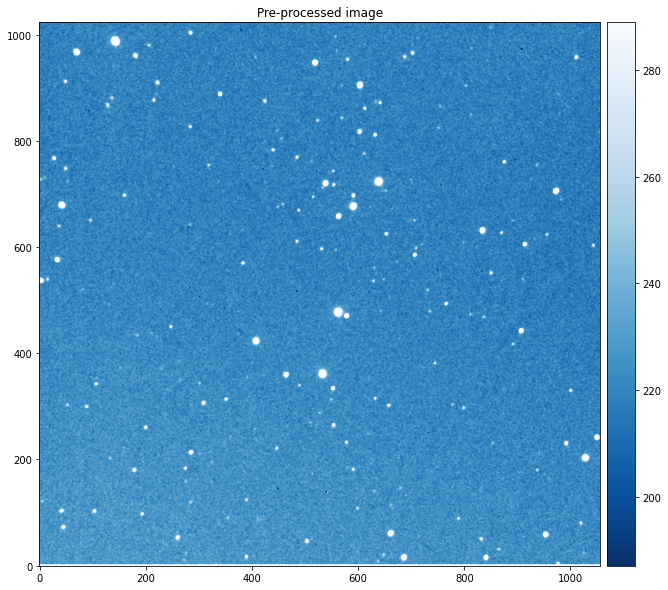

In [6]:
plots.imshow(image)
plt.title('Pre-processed image');

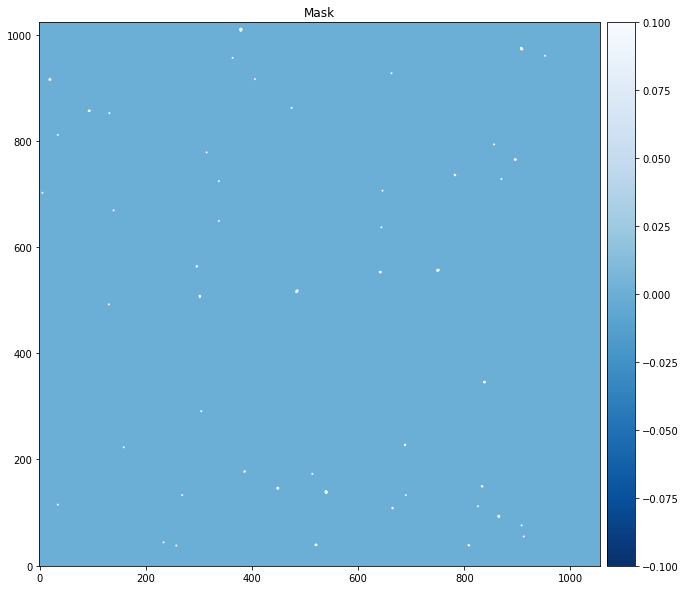

In [7]:
plots.imshow(mask)
plt.title('Mask');

# Detect and measure the objects

*STDPipe* currently contains two functions for detecting objects on the image, one based on external *SExtractor* binary, other - on Python *SEP* library. They have mostly identical signatures and arguments, but differ in minor details like meaning of returned detection flags etc.

They both return the results as a standard Astropy Table, ordered by the object brightness.

The detection in both cases is based on building the noise model through (grid-based) background and background rms estimation, and then extracting the groups of connected pixels above some pre-defined threshold. 

Optionally, the routines may automatically reject the objects detected too close to frame edge, and probably truncated or improperly measured - this is controlled by `edge` argument.

⚠️**The most important problem here is handling of blended objects, as the codes we are using can't properly deblend close groups, except for simplest cases**⚠️

In [8]:
# We will detect objects using SExtractor and get their measurements in apertures with 3 pixels radius
obj = photometry.get_objects_sextractor(image, mask=mask, aper=3.0, gain=gain, edge=10)
print(len(obj), 'objects detected')

166 objects detected


In [9]:
# Let's see 3 brightest objects
obj[:3]

mag,magerr,flux,fluxerr,x,y,xerr,yerr,a,b,theta,FLUX_RADIUS,fwhm,flags,bg,ra,dec
mag,mag,ct,ct,pix,pix,pix2,pix2,pix,pix,deg,pix,pix,,ct,pix,pix
float32,float32,float32,float32,float32,float32,float64,float64,float32,float32,float32,float32,float32,int16,float32,float32,float32
-13.6995,0.0019,301851.7,530.1235,563.1154,477.7703,3.7887485725e-03,4.0579191261e-03,1.919,1.758,69.81,1.718,2.98,0,220.1868,0.0000,0.0000
-13.3601,0.0023,220812.5,459.3036,533.6354,361.8254,4.2715591955e-03,4.6095116983e-03,1.930,1.738,66.60,1.780,3.15,0,222.0971,0.0000,0.0000
-13.2969,0.0023,208342.3,441.331,639.1481,723.3822,4.5623052323e-03,4.8312592341e-03,1.953,1.775,69.00,1.826,3.14,0,218.8498,0.0000,0.0000


Now we may measure the objects to get (a bit better) aperture photometry using the function based on [photutils](https://photutils.readthedocs.io/en/stable/) package. 

The flux is estimated as a sum of counts inside the aperture, minus sum of background values inside the same pixels. Background may be either:
 - global, estimated over a grid with size controlled throgh `bg_size` parameter in a way similar to how *SExtractor* is doing it
 - local, estimated as a mean value inside the annulus with inner and outer radii set through `bkgann` parameter, and centered on the object. 
     - ⚠️**Right now local background estimation is based on simple mean, so may be tainted by nearby stars!**⚠️
 
The error budget of photometric measurements consists of:
 - background noise inside the aperture - this part is empirically estimated and is quite robust
 - Poissonian noise of the source itself. This component is sensitive to knowing exact gain of the detector used



⚠️**Again, for close groups of objects the measurements will be biased!**⚠️

In [10]:
# Rough estimation of average FWHM of detected objects, taking into account only unflagged (e.g. not saturated) ones
fwhm = np.median(obj['fwhm'][obj['flags'] == 0])
print('Average FWHM is %.1f pixels' % fwhm)

Average FWHM is 4.1 pixels


In [11]:
# We will pass this FWHM to measurement function so that aperture and background radii will be relative to it. 
# We will also reject all objects with measured S/N < 5
obj = photometry.measure_objects(obj, image, mask=mask, fwhm=fwhm, gain=gain, aper=1.0, bkgann=[7, 10], sn=5, verbose=True)
print(len(obj), 'objects properly measured')

Estimating global background with 256x256 mesh
Subtracting global background: median 220.0 rms 1.63
Using global background noise map: median 13.0 rms 0.14 + gain 1.2
Scaling aperture radii with FWHM 4.1 pix
Using aperture radius 4.1 pixels
Using local background annulus between 28.8 and 41.1 pixels
Filtering out measurements with S/N < 5.0
148 objects properly measured


# Astrometric calibration

*STDPipe* has convenience code to peform "blind" astrometric calibration using Astrometry.Net, either online service (`astrometry.blind_match_astrometrynet` function) or locally-installed one (`astrometry.blind_match_objects`). It will allow to get an initial WCS solution, if it is not already available in FITS header.

In our case, FITS header already contains WCS solution, so we will just load it.

In [12]:
# Load initial WCS
wcs = WCS(header)

# Get the center position, size and pixel scale for the image
center_ra,center_dec,center_sr = astrometry.get_frame_center(wcs=wcs, width=image.shape[1], height=image.shape[0])
pixscale = astrometry.get_pixscale(wcs=wcs)

print('Frame center is %.2f %.2f radius %.2f deg, %.2f arcsec/pixel' % (center_ra, center_dec, center_sr, pixscale*3600))

Frame center is 154.61 -14.85 radius 0.31 deg, 1.52 arcsec/pixel


# Reference catalogue

Now we may download the catalogue for this sky region from Vizier. 

Catalogue name may be any Vizier identifier, or one of supported shortcuts for popular choices (**ps1, gaiadr2, gaiaedr3, usnob1, gsc, skymapper, apass, sdss, atlas, vsx**).

Column filters may be also provided to limit the output e.g. to brightest objects only.

Some of catalogue shortcuts (**ps1** and **gaiadr2**) also initiate augmenting the returned catalogue with photometric data not originally stored there, most notably - Johnson-Cousins **B, V, R and I** magnitudes. The transformations used for that are either taken from literature, or derived by me by cross-matching with Stetson standard stars.

In [13]:
#Let's get PanSTARRS objects brighter than r=17 mag
cat = catalogs.get_cat_vizier(center_ra, center_dec, center_sr, 'ps1', filters={'rmag':'<18'})
print(len(cat), 'catalogue stars')

505 catalogue stars


In [14]:
cat[:3]

RAJ2000,DEJ2000,e_RAJ2000,e_DEJ2000,objID,f_objID,Qual,_tab1_10,Ns,Nd,gmag,e_gmag,gKmag,e_gKmag,gFlags,rmag,e_rmag,rKmag,e_rKmag,rFlags,imag,e_imag,iKmag,e_iKmag,iFlags,zmag,e_zmag,zKmag,e_zKmag,zFlags,ymag,e_ymag,yKmag,e_yKmag,yFlags,B,V,R,I,g_SDSS,r_SDSS,i_SDSS,z_SDSS
deg,deg,arcsec,arcsec,,,,d,,,mag,mag,mag,mag,,mag,mag,mag,mag,,mag,mag,mag,mag,,mag,mag,mag,mag,,mag,mag,mag,mag,,,,,,,,,mag
float64,float64,float64,float64,int64,int64,int16,float64,int16,int16,float64,float32,float64,float32,int32,float64,float32,float64,float32,int32,float64,float32,float64,float32,int32,float64,float32,float64,float32,int32,float64,float32,float64,float32,int32,float64,float64,float64,float64,float64,float64,float64,float64
154.736155570,-15.137771850,0.0042,0.0062,89831547362115033,503635968,60,56251.627569440,5,67,17.0510,0.0035,17.1119,0.0043,115000,16.4280,0.0056,16.4824,0.0038,115000,16.1903,0.0025,16.2465,0.0030,115000,16.0951,0.0029,16.1529,0.0035,115000,16.0291,0.0044,16.0801,0.0068,115000,17.592630064,16.717640967999998,16.187746131000004,15.713474613999999,17.172879976926012,16.46135529189015,16.181923683082832,16.0951
154.671517130,-15.159172370,0.0037,0.0031,89801546715809348,503635968,60,56198.574571760,5,74,14.6526,0.0007,14.6955,0.0041,115000,14.0051,0.0036,14.0577,0.0014,115000,13.7456,0.0009,13.7925,0.0022,115000,13.6413,0.0012,13.6893,0.0013,115000,13.5526,0.0027,13.5464,0.0047,115000,15.207958099999997,14.30679095,13.76084036875,13.2647027875,14.779384473946688,14.03857927406794,13.737417814392941,13.6413
154.643863010,-15.143614170,0.0026,0.0025,89821546439378014,503635968,60,56197.320011570,5,79,16.7401,0.0052,16.7998,0.0031,115000,15.7642,0.0015,15.8180,0.0021,115000,15.3591,0.0024,15.4108,0.0024,115000,15.1842,0.0030,15.2330,0.0035,115000,15.0612,0.0030,15.1002,0.0039,115000,17.481324092960005,16.226482753520003,15.45917737059,14.819683352459998,16.913728789484033,15.79683986920278,15.35319287155778,15.1842


# Astrometric refinement

Now we may refine the astrometric solution based on the positions of detected objects and catalogue stars. *STDPipe* supports both calling *SCAMP* external binary (`astrometry.refine_wcs_scamp`, it will provide WCS solution based on PV distortions) or using simple positional list matching and *AstroPy*-based WCS fitting (`astrometry.refine_wcs`, SIP distortions). The difference in exact distortion representation is not important inside Python, but may become problematic if you save the WCS back to FITS header and try to use it with some software what do not handle it (e.g. *SWarp* and *SExtractor* do not know SIP).

Both methods are accessible uniformly through higher-level `pipeline.refine_astrometry` function. If the refinement fails, it will return `None` - do not forget to check for it!

In [15]:
# Let's use SCAMP for astrometric refinement.
wcs = pipeline.refine_astrometry(obj, cat, 5*pixscale, wcs=wcs, method='scamp', cat_col_mag='rmag', verbose=True)

if wcs is not None:
    # Update WCS info in the header
    astrometry.clear_wcs(header, remove_comments=True, remove_underscored=True, remove_history=True)
    header.update(wcs.to_header(relax=True))

Astrometric refinement using 7.6 arcsec radius, photometric matching and scamp WCS fitting
Using user-provided local catalogue
Will run SCAMP like that:
/usr/local/bin/scamp /tmp/scampxf6fwdo0/objects.cat -VERBOSE_TYPE QUIET -SOLVE_PHOTOM N -CHECKPLOT_TYPE NONE -WRITE_XML Y -XML_NAME /tmp/scampxf6fwdo0/scamp.xml -PROJECTION_TYPE TPV -CROSSID_RADIUS 7.609978569318471 -DISTORT_DEGREES 1 -HEADER_NAME /tmp/scampxf6fwdo0/objects.head -ASTREF_CATALOG FILE -ASTREFCAT_NAME /tmp/scampxf6fwdo0/catalogue.cat
SCAMP run successfully
96 matches, chi2 5.3
Got WCS solution with CTYPE1 = RA---TPV  and without PV keywords, fixing it
Astrometric accuracy: 0.00" 0.00"


# Photometric calibration

Photometric calibration is performed by positionally matching detected objects with catalogue stars, and then building the photometric model for their instrumental magnitudes.

The model includes:
 - catalogue magnitude
 - (optionally spatially varying) zero point
 - (optionally) catalogue color
 - (very optionally) additive flux term, corresponding e.g. to biased background estimation
 - (very very optionally) intrinsic scatter on top of measurement errors
 
and looks like that:
$$ 
\mbox{Catalogue} = \mbox{Instrumental} + C\cdot\mbox{color} + \mbox{polynomial}(x, y, degree) + \mbox{err}
$$

where $\mbox{Catalogue}$ is e.g. $\mbox{V}$ magnitude and $\mbox{color}$ is e.g $\mbox{B-V}$

This is equivalent to the instrumenmtal photometric system defined as $\mbox{V} - C\cdot(\mbox{B-V})$.

The low-level calibration is implemented in `photometry.match` function, and wrapped into a bit higher-level and easier to use `pipeline.calibrate_photometry`. The routines perform an iterative fitting with rejection of pairs deviating too much (more than `threshold` sigmas) from the model. Optional intrinsic scatter (specified through `max_intrinsic_rms` parameter) may help accounting for the effects of e.g. multiplicative noise (flatfielding, subpixel sensitivity variations, etc). 

⚠️**The calibration (or zero point, or systematic) error is currently estimated as a fitted model error, and is typically way too small. Most probably the method is wrong!**⚠️

In [16]:
# Photometric calibration using 2 arcsec matching radius, r magnitude, g-r color and second order spatial variations
m = pipeline.calibrate_photometry(obj, cat, sr=2/3600, cat_col_mag='rmag', cat_col_mag1='gmag', cat_col_mag2='rmag', max_intrinsic_rms=0.02, order=2, verbose=True)

# The code above automatically augments the object list with calibrated magnitudes, but we may also do it manually
obj['mag_calib'] = obj['mag'] + m['zero_fn'](obj['x'], obj['y'])
obj['mag_calib_err'] = np.hypot(obj['magerr'], m['zero_fn'](obj['x'], obj['y'], get_err=True))

Performing photometric calibration of 148 objects vs 505 catalogue stars
Using 2.0 arcsec matching radius, rmag magnitude and spatial order 2
Using (gmag - rmag) color for color term
156 initial matches between 148 objects and 505 catalogue stars, sr= 2.0 arcsec
Median separation is 0.2631103545673489 arcsec
Fitting the model with spatial_order = 2
Using robust fitting
Using color term
Iteration 0 : 139 / 156 - 0.27209094197195716 0.12282950029064622 - 4.274832451172161
Fitting converged
139 good matches
Intrinsic scatter is 0.02
Color term is -0.11305447774398515
Photometric calibration finished successfully.
Color term is -0.11


There is a handy plotting function useful for quick checking of fitting quality and uncorrected trends. It marks the stars used for final model fit with red dots, and flagged (e.g. saturated) stars rejected from the fitting from the start - with yellow diagonal crosses.

(0.0, 1.5)

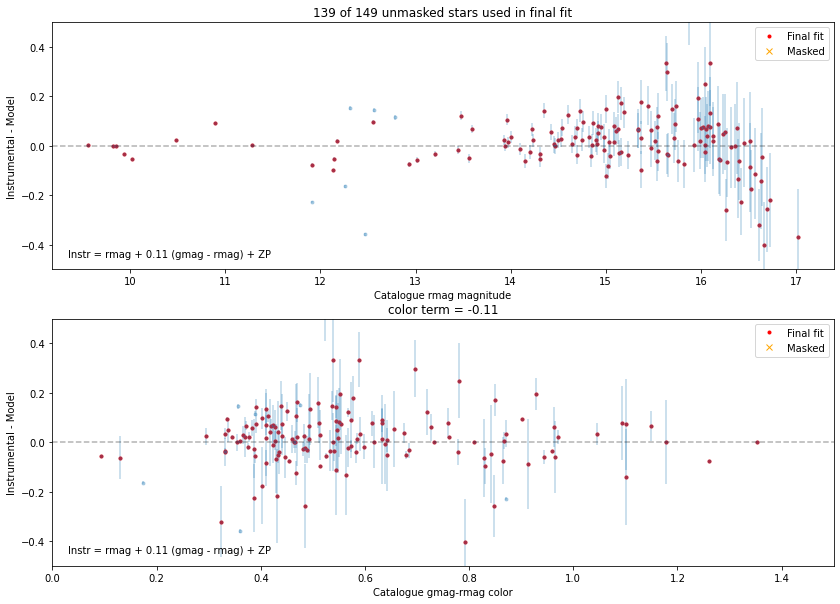

In [17]:
plt.subplot(211)
plots.plot_photometric_match(m)
plt.ylim(-0.5, 0.5)

plt.subplot(212)
plots.plot_photometric_match(m, mode='color')
plt.ylim(-0.5, 0.5)
plt.xlim(0.0, 1.5)

## Simple catalogue-based transient detection

Anyway, at this point we already have the detections of all sufficiently isolated and sufficiently bright objects on the frame, and photometric calibration for them. 

Some transients may already be detected by comparing the detected objects with catalogue, and selecting the ones that do not have any counterpart there. This approach is limited, as
 - it does not play well with blended objects, as they are often being detected as a single extended thing with centroid separated from the centres of individual components
 - it does not easily allow to detect flares or low-amplitude variability of objects that are present in the catalogue
 
Anyway, let's do it. We have a dedicated routine `pipeline.filter_transient_candidates` that accepts the list of objects, and filters out the following things:
 - flagged ones, i.e. with `obj['flags'] != 0`
 - positionally coincident with stars from provided cataloge table (if `cat != None`)
 - positionally coincident with stars from Vizier catalogues specified as a list of names (if `vizier` list is non-empty)
 - positionally and temporally coincident with Solar system objects from SkyBoT service (if `skybot = True` and `time` is provided, or is present in the object list as a column)
 - positionally and temporally coincident with NED objects (if `ned = True`)

As we are already using PanSTARRS as a reference catalogue, let's limit Vizier filtering to variable stars only. And as an input list of candidates, let's just use all detected objects.

In [18]:
# Filtering of transient candidates
candidates = pipeline.filter_transient_candidates(obj, cat=cat, sr=2/3600, vizier=['vsx'], verbose=True)

Candidate filtering routine started with 148 initial candidates and 2.0 arcsec matching radius
148 of them are unflagged
1 of them are not matched with reference catalogue
1 remains after matching with AAVSO VSX
1 candidates remaining after filtering


Now we may create cutouts for these surviving candidates and vizualize them, also downloading corresponding cutouts from PanSTARRS itself

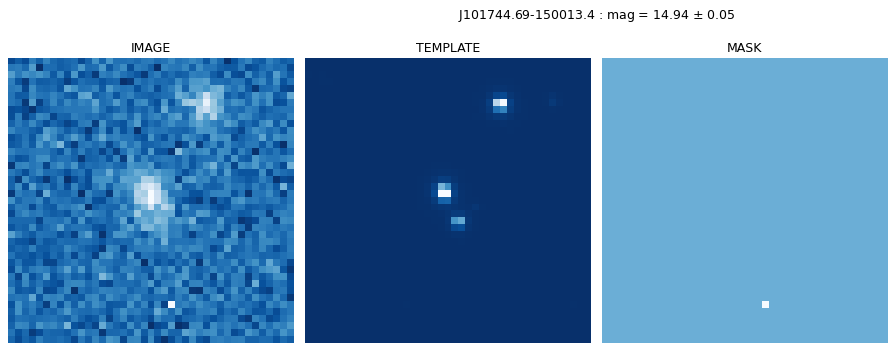

In [19]:
for i,cand in enumerate(candidates):
    # Create the cutout from image based on the candidate
    cutout = cutouts.get_cutout(image, cand, 20, mask=mask, header=header)
    # We may directly download the template image for this cutout from HiPS server - same scale and orientation
    cutout['template'] = templates.get_hips_image('PanSTARRS/DR1/r', header=cutout['header'])[0]
    
    # We do not have difference image, so it will only display original one, template and mask
    plots.plot_cutout(cutout, qq=[0.5, 99.9], stretch='linear')
    plt.show()

Second one is definitely the transient we are looking for, but the first, brighter one is an unresolved blend. It may be additionally filtered out based on PSF fitting $\chi^2$, or `spread_model` field, or large photometric error, or morphological characteristics.

# Image subtraction

More accurate and stable transient detection is performed using *image subtraction*. 

Image subtraction in *STDPipe* is performed using [HOTPANTS](https://github.com/acbecker/hotpants) code, and needs the following:
 - template image, astrometrically aligned with science image
 - masks for both template and science images
 - noise models for the template and science images

The template may be some image or coadd from the same instrument or some other archive (e.g. *STDPipe* supports downloading images from PanSTARRS through `template.get_ps1_skycells` routine) - then it should be astrometrically aligned with science image. Currently no options for such alignment are implemented in *STDPipe*, but it may easily be handled by external Python libraries like [AstroAlign](https://github.com/quatrope/astroalign) or [MontagePy](http://montage.ipac.caltech.edu/docs/montagePy-UG.html). It will be covered in additional tutorial.

The simpler way that is currently implemented in *STDPipe* is downloading the images from CDS [hips2fits](http://alasky.u-strasbg.fr/hips-image-services/hips2fits) service, which is serving the cutouts from any survey available in HiPS ([Hierarchical Progressive Surveys](http://aladin.u-strasbg.fr/hips/)) format. Takeaway message is:
 - any survey [listed here](http://aladin.u-strasbg.fr/hips/list) may be used for getting the template
     - most important for us are PanSTARRS ($\delta>-30$ deg) and SkyMapper ($\delta<0$ deg)
     - for PanSTARRS we automatically convert original `asinh` flux scaling to linear counts
 - the image may be requested in any projection specified by WCS header, so no re-projection is necessary
 - ⚠️**HiPS projection algorithm is not *exactly* flux conserving, but it is important only for undersampled cases, i.e. for pixel scale worse than 1 arcsec/pixel**
     - as a workaround, we may request the image with 2x resolution and then downscale it (has to be done manually for now)
 - HiPS represents surveys masked pixels as `NaNs`, but its projection algorithm may smooth them out, so masking should be handled with care



In [20]:
# Get r band image from PanSTARRS with science image original resolution and orientation
# tmpl = templates.get_hips_image('PanSTARRS/DR1/r', wcs=wcs, width=image.shape[1], height=image.shape[0], get_header=False)

# Get r band image from PanSTARRS with 2x resolution (as we have large pixel scale) and downsample it 
tmpl = templates.get_hips_image('PanSTARRS/DR1/r', wcs=wcs[::0.5,::0.5], width=image.shape[1]*2, height=image.shape[0]*2, get_header=False)
tmpl = utils.rebin_image(tmpl, 2)

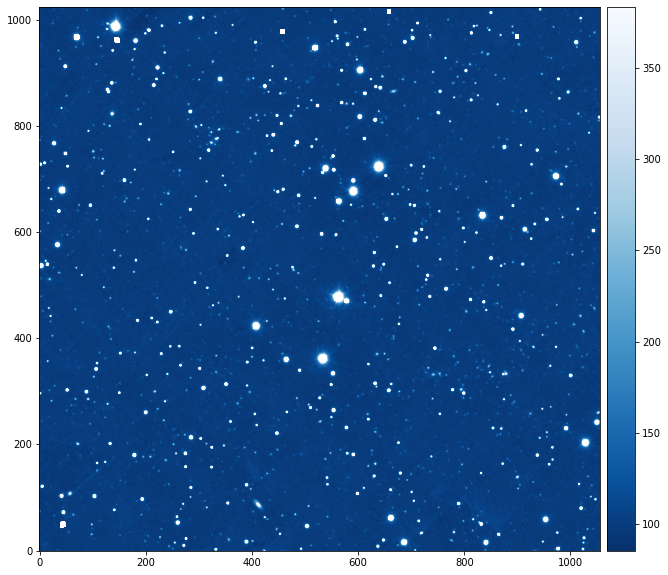

In [21]:
plots.imshow(tmpl)

## Template masking

Templates, especially acquired from different instruments or surveys, are not perfect, and some pixels on them should be masked before image subtraction. In HiPS case, where no additional masks are available for download, we should do the following:
 - mask `NaNs` in the template, as they represent (some fraction of) originally masked pixels from the survey
 - mask the stars that are brighter than survey saturation limit, even if HiPS does not contain `NaNs` for them
 
The latter is especially important for red bands of PanSTARRS, where e.g. the stars above $r\approx15$ are saturated on individual exposures, but not flagged on publicly available coadds!

(-2.0, 2.0)

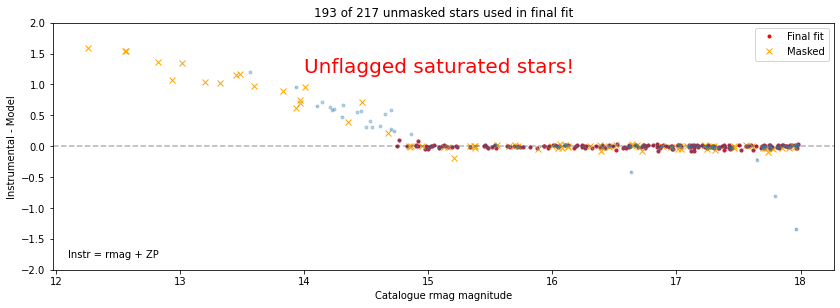

In [22]:
# To demonstrate it, let's perform the photometry on template and match it with catalogue
tobj = photometry.get_objects_sextractor(tmpl, mask=~np.isfinite(tmpl), wcs=wcs, aper=3, gain=0)
m = pipeline.calibrate_photometry(tobj, cat, sr=1/3600, cat_col_mag='rmag', cat_col_mag_err='e_rmag', max_intrinsic_rms=0.1, verbose=False)
plt.subplot(211)
plots.plot_photometric_match(m, mode='mag')
plt.text(14, 1.2, 'Unflagged saturated stars!', color='red', fontsize=20)
# plt.text(15.2, 0.4, 'Scatter due to undersampled HiPS template', color='blue', fontsize=12)
plt.ylim(-2, 2)

The routine `templates.mask_template` masks the template pixels that are either
 - set to `NaN`
 - close to the positions of catalogue stars brighter some threshold
 
It also optionally dilates the resulting mask, so that the pixels close to already masked are masked too (wings of saturated stars, etc)

279 template pixels masked after NaN checking
331 template pixels masked after checking saturated (rmag < 15.0) stars
Dilating the mask with 3 x 3 kernel
3075 template pixels masked after dilation


Text(0.5, 1.0, 'Template mask')

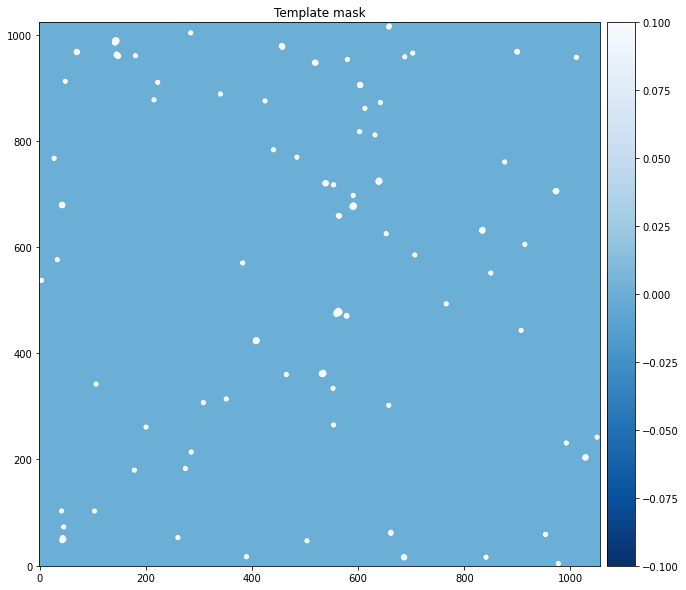

In [23]:
tmask = templates.mask_template(tmpl, cat, cat_col_mag='rmag', cat_saturation_mag=15, wcs=wcs, dilate=3, verbose=True)

plots.imshow(tmask)
plt.title('Template mask')

# Subtracting the images

Image subtraction is implemented in `subtraction.run_hotpants` routine, that implements the following logic on top of running `hotpants` binary:
 - finding optimal convolutuon kernel sizes based on image and template FWHM
 - filling in necessary parameters like min/max pixel values, etc
     - also, all parameters may be overwritten or added by passing them through `extra` argument, allowing full control over the code
 - (optionally) building noise models for the image and template based on their background statistics and gain, so that they may be e.g. background-subtracted
     - noise model is again based on background rms + Poisson contribution from the object flux
 - (optionally) constructing the list of stamp positions used for fitting the convolution kernel based on user-supplied list of coordinates (e.g. detected objects)

The routine optionally returns, along with difference image, the template convolved with the kernel (so supposedly matching the science image resolution), noise-scaled difference image, and the error model. The latters may be used to assess the significance of detections.

In [24]:
# Run the subtraction getting back all possible image planes, assuming the template to be noise-less, and estimating image noise model from its statistics.

import photutils

bg = photutils.Background2D(image, 128, mask=mask, exclude_percentile=30).background
tbg = photutils.Background2D(tmpl, 128, mask=tmask, exclude_percentile=30).background
diff,conv,sdiff,ediff = subtraction.run_hotpants(image-bg, tmpl-tbg, mask=mask, template_mask=tmask, get_convolved=True, get_scaled=True, get_noise=True, image_fwhm=fwhm, template_fwhm=1.5, image_gain=gain, template_gain=1e6, err=True, verbose=True)

Building noise model from the image
Will run HOTPANTS like that:
hotpants -inim /tmp/hotpantslbid64ih/image.fits -tmplim /tmp/hotpantslbid64ih/template.fits -outim /tmp/hotpantslbid64ih/diff.fits -savexy /tmp/hotpantslbid64ih/stamps.reg -imi /tmp/hotpantslbid64ih/imask.fits -tmi /tmp/hotpantslbid64ih/tmask.fits -il -133.27101684597326 -iu 32076.082543490873 -tl -56.857770920338496 -tu 27304.928530742884 -tuk 27304.928530742884 -n i -allm -c t -hki -ko 0 -bgo 0 -v 2 -ini /tmp/hotpantslbid64ih/err.fits -ng 3 6 0.8140944182059566 4 1.6281888364119133 2 3.2563776728238265 -r 13 -rss 17 -ig 1.167 -tg 1000000.0
HOTPANTS run succeeded
77 stamps used


Text(0.5, 1.0, 'Noise-scaled difference image')

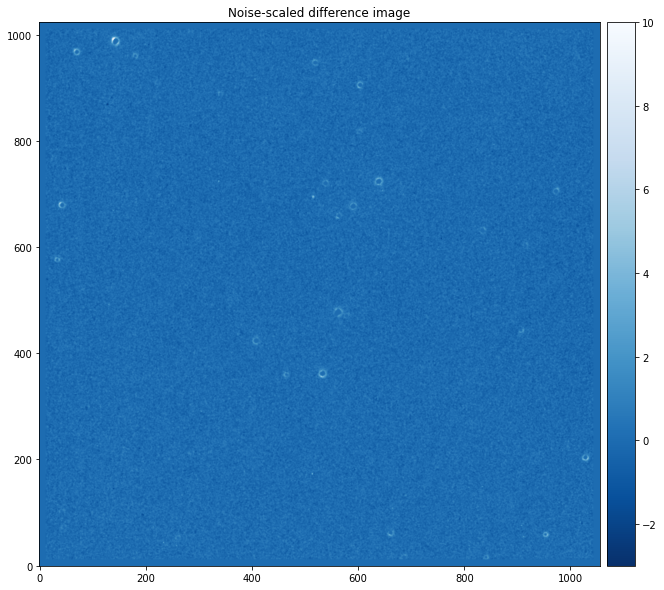

In [25]:
sdiff[tmask] = 0.0
plots.imshow(sdiff, vmin=-3, vmax=10)
plt.title('Noise-scaled difference image')


# Transient detection on difference image

Transient detection on difference image differs from the one we did on original image in two ways:
 - there are much less remaining sources
 - most of them are subtraction artefacts that have different PSF shape, so may be filtered out
 - we know the noise model for the difference image
 
Knowing noise model also helps filtering out subtraction artefacts as they mostly happen in high-noise regions (inside stellar footprints).

So we will use the noise model, and will perform PSF photometry. We will also show how to pass extra parameters to *SExtractor* to get extra fields in the output, inspect checkimages, etc. We will also use PSF model built by *PSFEx* (see appendix) for getting some parameters based on model fitting.

In [26]:
dmask = diff == 1e-30 # Bad pixels as marked by HOTPANTS

# Get PSF model and store it to temporary file
psf_model = psf.run_psfex(image, mask=mask, order=0, gain=gain, psffile='/tmp/psf.psf', verbose=True)

# Run SExtractor on difference image with custom noise model, returning object footprints and some additional fields
sobj,segm = photometry.get_objects_sextractor(diff, mask=mask|tmask|dmask, err=ediff, edge=10, wcs=wcs, aper=5.0, extra_params=['CLASS_STAR', 'NUMBER'], extra={'SEEING_FWHM':fwhm, 'STARNNW_NAME':'/usr/share/sextractor/default.nnw'}, checkimages=['SEGMENTATION'], psf='/tmp/psf.psf')

# Perform forced aperture photometry, again with custom noise model and forced zero background level
sobj = photometry.measure_objects(sobj, diff, mask=mask|tmask|cmask|dmask, fwhm=fwhm, aper=1.0, bkgann=[5, 7], sn=3, verbose=True, bg=0, err=ediff)

# The difference is in original image normalization, so we know photometric zero point
sobj['mag_calib'] = sobj['mag'] + m['zero_fn'](sobj['x'], sobj['y'])
sobj['mag_calib_err'] = np.hypot(sobj['magerr'], m['zero_fn'](sobj['x'], sobj['y'], get_err=True))

# We may immediately reject flagged objects as they correspond to imaging artefacts (masked regions)
sobj = sobj[sobj['flags'] == 0]

print(len(sobj), 'transient candidates found in difference image')

Extracting PSF using vignette size 19 x 19 pixels
Will run SExtractor like that:
/usr/bin/sex /tmp/psfex_rwsdir3/image.fits -VERBOSE_TYPE QUIET -DETECT_MINAREA 5 -GAIN 1.167 -DETECT_THRESH 2.0 -WEIGHT_TYPE BACKGROUND -MASK_TYPE NONE -SATUR_LEVEL 31971.915038440507 -FLAG_IMAGE /tmp/psfex_rwsdir3/flags.fits -PHOT_APERTURES 6.0 -PARAMETERS_NAME /tmp/psfex_rwsdir3/cfg.param -CATALOG_NAME /tmp/psfex_rwsdir3/out.cat -CATALOG_TYPE FITS_LDAC -FILTER Y -FILTER_NAME /tmp/psfex_rwsdir3/kernel.txt
SExtractor run succeeded
Will run PSFEx like that:
/usr/local/bin/psfex /tmp/psfex_rwsdir3/out.cat -VERBOSE_TYPE QUIET -CHECKPLOT_TYPE NONE -CHECKIMAGE_TYPE NONE -PSFVAR_DEGREES 0 -WRITE_XML N
PSFEx run succeeded
Loading PSF model from /tmp/psfex_rwsdir3/out.psf
PSF model 25 x 25 pixels, FWHM 3.6 pixels, sampling 0.77, degree 0
PSF model stored to /tmp/psf.psf
Subtracting user-provided background: median 0.0 rms 0.00
Using user-provided noise map: median 13.1 rms 0.98
Scaling aperture radii with FWHM 4.1

In [27]:
candidates = pipeline.filter_transient_candidates(sobj, sr=2/3600, flagged=True, vizier=['ps1', 'vsx'], skybot=True, time=time, verbose=True)

Candidate filtering routine started with 1 initial candidates and 2.0 arcsec matching radius
1 of them are unflagged
1 remains after matching with PanSTARRS DR1
1 remains after matching with AAVSO VSX
1 remains after matching with SkyBot
1 candidates remaining after filtering


Candidate 0 with mag = 19.27 +/- 0.09 at x/y = 515.6 694 and RA/Dec = 154.6060 -14.9317
SPREAD_MODEL = 0.002 +/- 0.003, CLASS_STAR = 0.72


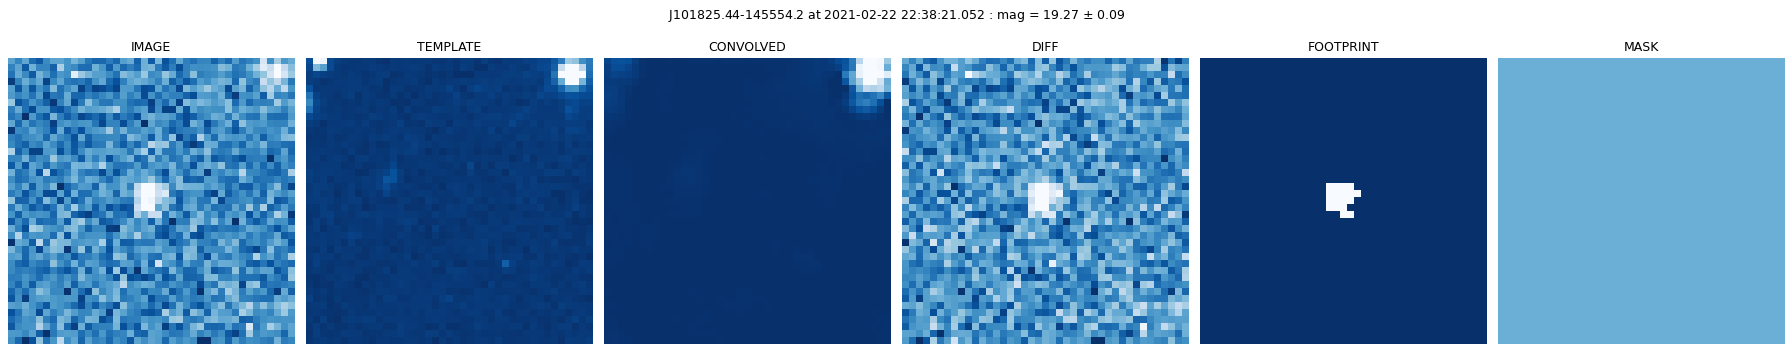

In [28]:
for i,cand in enumerate(candidates):
        print('Candidate %d with mag = %.2f +/- %.2f at x/y = %.1f %.1d and RA/Dec = %.4f %.4f' % (i, cand['mag_calib'], cand['mag_calib_err'], cand['x'], cand['y'], cand['ra'], cand['dec']))
        
        print('SPREAD_MODEL = %.3f +/- %.3f, CLASS_STAR = %.2f' % (cand['spread_model'], cand['spreaderr_model'], cand['CLASS_STAR']))
        
        cutout = cutouts.get_cutout(image, cand, 20, mask=mask|tmask|dmask, diff=diff, template=tmpl, convolved=conv, err=ediff, footprint=(segm==cand['NUMBER']), header=header, filename=filename, time=time)
        
        plots.plot_cutout(cutout, ['image', 'template', 'convolved', 'diff', 'footprint', 'mask'], qq=[0.5, 99.5], stretch='linear')
        plt.show()

We successfully recovered the actual transient, and this time no blended stars are in our way! 

# Appendix

## PSF photometry

We do not have any dedicated PSF photometry code implemented in *STDPipe* right now, but we may use *SExtractor* + *PSFEx* to do it. It is a bit limited in scope, as it does not support PSF-based detection and deblending, nor group photometry. But it often helps anyway, so let's show how to do it.

`psf.run_psfex` is a simple wrapper around *PSFEx* that automatically builds PSF model from the image, and returns it as an object (usable e.g. for placing realistically looking artificial stars into the image). However, we do not (yet) have the code to write this structure back to file, so in order to use it inside *SExtractor* we need to directly ask the routine to store it to some temporary file. Of course, in real pipeline the filename should be randomly generated, and the file should be disposed after use!

Then, `photometry.get_objects_sextractor` accepts an argument `psf` which should be the filename of PSF model. Then it will automatically use it, and add several extra columns to the output (**mag_psf, magerr_psf, chi2_psf, spread_model**, etc). Finally, we may use these measurements for photometric calibration.

In [29]:
# We do not have enough stars to study PSF spatial variance, so we use order=0 here
psf_model = psf.run_psfex(image, mask=mask, order=0, gain=gain, psffile='/tmp/psf.psf', verbose=True)

obj_psf = photometry.get_objects_sextractor(image, mask=mask, aper=3.0, edge=10, gain=gain, wcs=wcs, psf='/tmp/psf.psf', verbose=False)

m_psf = pipeline.calibrate_photometry(obj_psf, cat, sr=1/3600, obj_col_mag='mag_psf', obj_col_mag_err='magerr_psf', cat_col_mag='rmag', cat_col_mag1='gmag', cat_col_mag2='rmag', order=2, max_intrinsic_rms=0.02, verbose=False)

Extracting PSF using vignette size 19 x 19 pixels
Will run SExtractor like that:
/usr/bin/sex /tmp/psfexffhb7bqs/image.fits -VERBOSE_TYPE QUIET -DETECT_MINAREA 5 -GAIN 1.167 -DETECT_THRESH 2.0 -WEIGHT_TYPE BACKGROUND -MASK_TYPE NONE -SATUR_LEVEL 31971.915038440507 -FLAG_IMAGE /tmp/psfexffhb7bqs/flags.fits -PHOT_APERTURES 6.0 -PARAMETERS_NAME /tmp/psfexffhb7bqs/cfg.param -CATALOG_NAME /tmp/psfexffhb7bqs/out.cat -CATALOG_TYPE FITS_LDAC -FILTER Y -FILTER_NAME /tmp/psfexffhb7bqs/kernel.txt
SExtractor run succeeded
Will run PSFEx like that:
/usr/local/bin/psfex /tmp/psfexffhb7bqs/out.cat -VERBOSE_TYPE QUIET -CHECKPLOT_TYPE NONE -CHECKIMAGE_TYPE NONE -PSFVAR_DEGREES 0 -WRITE_XML N
PSFEx run succeeded
Loading PSF model from /tmp/psfexffhb7bqs/out.psf
PSF model 25 x 25 pixels, FWHM 3.6 pixels, sampling 0.77, degree 0
PSF model stored to /tmp/psf.psf


(0.0, 1.5)

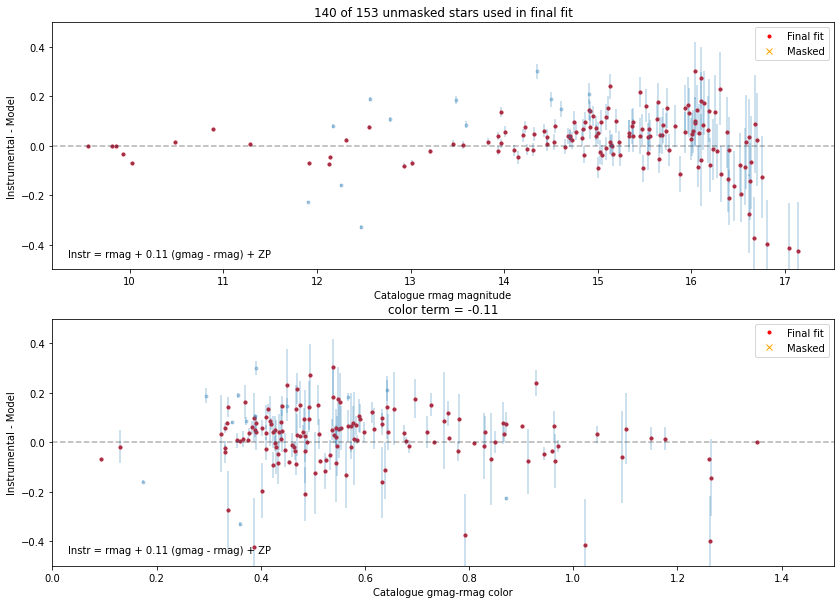

In [30]:
plt.subplot(211)
plots.plot_photometric_match(m_psf)
plt.ylim(-0.5, 0.5)

plt.subplot(212)
plots.plot_photometric_match(m_psf, mode='color')
plt.ylim(-0.5, 0.5)
plt.xlim(0.0, 1.5)

Well, it does not help much in our specific case.

## Testing flux conservation in HiPS images

We may directly see the effect of *inexact* flux conservation in HiPS images depending on requested pixel scale by comparing the photometry on HiPS PanSTARRS images with the "official" photometric catalogue derived (supposedly) from the same coadds. Let's do it!

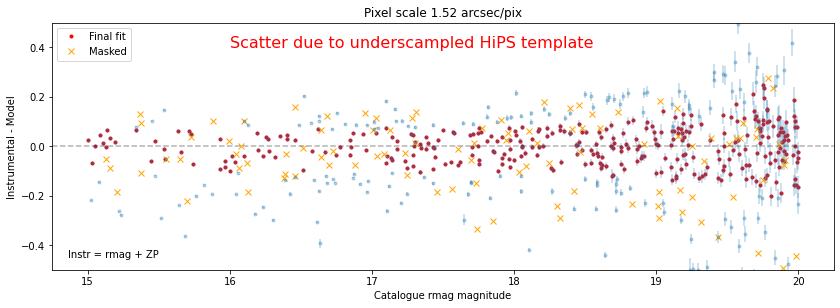

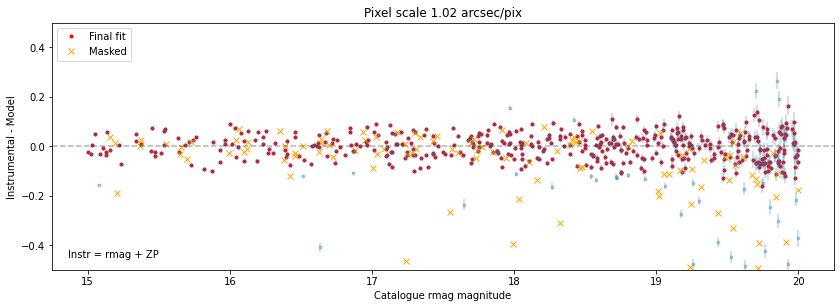

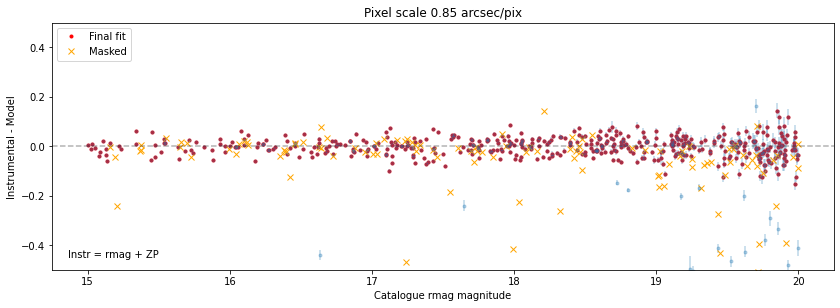

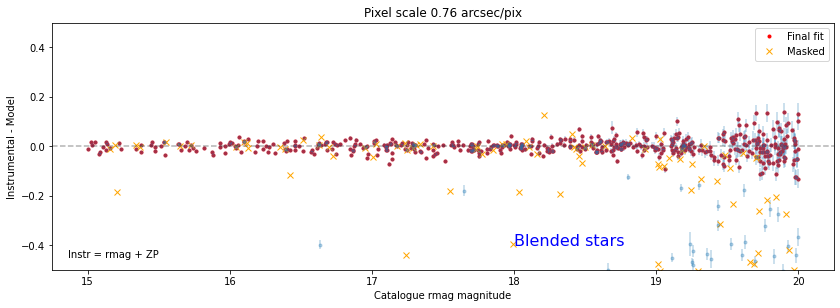

In [31]:
cat1 = catalogs.get_cat_vizier(center_ra, center_dec, center_sr, 'ps1', filters={'rmag':'15..20'})

for scale in [1, 1.5, 1.8, 2]:
    wcs1 = wcs[::1/scale, ::1/scale] # Rescaled WCS solution
    tmpl1 = templates.get_hips_image('PanSTARRS/DR1/r', wcs=wcs1, width=image.shape[1]*scale, height=image.shape[0]*scale, get_header=False)
    
    tobj = photometry.get_objects_sextractor(tmpl1, mask=~np.isfinite(tmpl1), wcs=wcs1, aper=2*scale, gain=0)
    m = pipeline.calibrate_photometry(tobj, cat1, sr=1/3600, cat_col_mag='rmag', cat_col_mag_err='e_rmag', max_intrinsic_rms=0.02, bg_order=2, verbose=False)

    plt.subplot(211)
    plots.plot_photometric_match(m, mode='mag')
    plt.ylim(-0.5, 0.5)
    plt.title('Pixel scale %.2f arcsec/pix' % (3600*astrometry.get_pixscale(wcs=wcs1)))
    if scale == 1:
        plt.text(16, 0.4, 'Scatter due to underscampled HiPS template', color='red', fontsize=16)
    if scale == 2:
        plt.text(18, -0.4, 'Blended stars', color='blue', fontsize=16)
        
    plt.show()

So it seems using the pixel scale a bit below 1 arcsecond per pixel gives quite acceptable photometric accuracy of returned HiPS image.

## Convenience routines: splitting the image into sub-images

Often you have quite large image, with significant variation of PSF, background etc over it. Such frames are not very well suited for image subtraction, as convolution kernel will become unstable and / or unable to properly match the resolutions of image and template. 

So, for such images, it is better to split them into smaller pieces and do image subtraction on the latters. When splitting, however, you have to also split the mask, update WCS solution and FITS header, maybe select a subset of catalogue stars, etc etc. And we have a dedicated routine for doing just that!

In [32]:
# Crop the image (mask, header, WCS, object list and catalogue too) into several pieces, adding 10 pixels wide overlap
for x0, y0, image1, mask1, header1, wcs1, obj1, cat1 in pipeline.split_image(image, nx=2, mask=mask, header=header, wcs=wcs, obj=obj, cat=cat, overlap=10, get_origin=True, verbose=True):
    # Do something useful on the sub-images here!
    pass

Will split the image (1056x1024) into 2x2 pieces with 528x512 pixels size and 10 pix overlap
Block 0: 0 0 - 538 522
Block 1: 0 502 - 538 1024
Block 2: 518 0 - 1056 522
Block 3: 518 502 - 1056 1024


## Placing artificial stars into the image

We have a simple routine, `pipeline.place_random_stars`, that generates the list of randomly placed artificial stars with log-uniform flux distribution and places them inside the image. The stars are based on user-provided PSF model, and thus should be identical in shape to original image contents. It may be used for experiments with detection efficiency. It is covered in more details [in a separate notebook](simulated_stars.ipynb).

